<a href="https://colab.research.google.com/github/seepala98/EVA4-P2/blob/master/session7_var_autodecoder/notebooks/VAE_onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Deep Convolutional GANs
Reference: https://arxiv.org/pdf/1511.06434.pdf

#Mount

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Import

In [ ]:
import torch
import torchvision
import numpy as np
import datetime
import os, sys
from matplotlib.pyplot import imshow, imsave
# import cudas
# import general_utils
# from Transform_utils.transforme_album import Data
# from models.Vae import VAE
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

#Unzip

In [ ]:
!unzip -q '/content/gdrive/My Drive/eva-4/Phase-2/Session-7/IndianCars.zip' -d /content/ZData/
!mkdir /content/ZData/Train
!mv /content/ZData/IndianCars /content/ZData/Train/

#Models

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
from tqdm.notebook import tqdm

def getmeanstd(path):
  count = 0
  sum_mean = [0, 0, 0]; sum_std = [0, 0, 0]
  for i in tqdm(glob.glob(path)):
    img = cv2.imread(i)
    if img is None:
      print(i)
      continue
    r = img[:,:,2]/255
    g = img[:,:,1]/255
    b = img[:,:,0]/255
    sum_mean[0] += np.mean(r)
    sum_std[0] += np.std(r)
    sum_mean[1] += np.mean(g)
    sum_std[1] += np.std(g)
    sum_mean[2] += np.mean(b)
    sum_std[2] += np.std(b)
    count=count+1
    if(count>100000):
      break
    
  sum_mean[0] = sum_mean[0]/(count)
  sum_std[0] = sum_std[0]/count
  sum_mean[1] = sum_mean[1]/count
  sum_std[1] = sum_std[1]/count
  sum_mean[2] = sum_mean[2]/count
  sum_std[2] = sum_std[2]/count
  print("Mean: -",sum_mean)
  print("stdDev: -", sum_std)
  return sum_mean, sum_std

In [ ]:
getmeanstd('/content/ZData/Train/IndianCars/*')


Mean: - [0.7270403932555627, 0.7072142289814668, 0.70776155468568]
stdDev: - [0.3278671301794192, 0.34016835043307697, 0.33884424002558416]


([0.7270403932555627, 0.7072142289814668, 0.70776155468568],
 [0.3278671301794192, 0.34016835043307697, 0.33884424002558416])

In [ ]:
from albumentations import *
from albumentations.pytorch import ToTensor
import numpy as np

class TestAlbumentation():
  def __init__(self):
    self.test_transform = Compose([
      Resize(224, 224, interpolation=1, always_apply=False, p=1),
      Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225],
      ),
      ToTensor()
    ])

  def __call__(self, img):
    img = np.array(img)
    img = self.test_transform(image = img)['image']
    return img

In [ ]:
from albumentations import *
from albumentations.pytorch import ToTensor
import numpy as np

class TrainAlbumentation():
  def __init__(self):
    self.train_transform = Compose([
      Resize(128, 128, interpolation=1, always_apply=False, p=1),
      HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.5),
      Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225],
      ),
      ToTensor()
    ])

  def __call__(self, img):
    img = np.array(img)
    img = self.train_transform(image = img)['image']
    return img

In [ ]:
import torch
import torchvision
import os
from torchvision import datasets

SEED = 1

class Data():

  def __init__(self):
    self.train_album = TrainAlbumentation()
    self.test_album =TestAlbumentation()

  def getTrainDataSet(self, train=True):
    datadir = '/content/ZData/Train'
    train_data = datasets.ImageFolder(datadir,
                    transform=self.train_album)
    num_train = len(train_data)
    print("Train Data size", num_train)
    return train_data

  def getTestDataSet(self, train=False):
    datadir = '/content/ZData/Val'
    test_data = datasets.ImageFolder(datadir,
                    transform=self.test_album)
    num_test = len(test_data)
    print("Test Data size", num_test)
    return test_data

  def getDataLoader(self, dataset, batches):
    # checking CUDA
    self.cuda = torch.cuda.is_available()
    # For reproducibility
    torch.manual_seed(SEED)
    if self.cuda:
      torch.cuda.manual_seed(SEED)

    # dataloader arguments - something you'll fetch these from cmdprmt
    dataloader_args = dict(shuffle=True, batch_size=batches, num_workers=4, pin_memory=True) if self.cuda else dict(shuffle=True, batch_size=64)

    # train dataloader
    self.dataset_loader = torch.utils.data.DataLoader(dataset, **dataloader_args)

    return self.dataset_loader

    
  def getGradCamDataLoader(self, dataset):
  # checking CUDA
    self.cuda = torch.cuda.is_available()
    # For reproducibility
    torch.manual_seed(SEED)
    if self.cuda:
      torch.cuda.manual_seed(SEED)

    # dataloader arguments - something you'll fetch these from cmdprmt
    dataloader_args = dict(shuffle=True, batch_size=1, num_workers=1, pin_memory=True) if self.cuda else dict(shuffle=True, batch_size=1)

    # train dataloader
    self.dataset_loader = torch.utils.data.DataLoader(dataset, **dataloader_args)

    return self.dataset_loader

In [ ]:
data = Data()
trainset = data.getTrainDataSet(train=True)
trainloader = data.getDataLoader(trainset, 32)
trainloader1 = data.getDataLoader(trainset, 8)
classes = ('Cars')
batch_size = 32
# get some random training images
dataiter = iter(trainloader1)
images, labels = dataiter.next()
print(images.shape)
print(labels)


Train Data size 512
torch.Size([8, 3, 128, 128])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


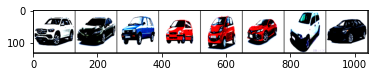

In [ ]:
imshow(torchvision.utils.make_grid(images))

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

In [ ]:
SEED = 1
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!rm -rf /content/ZData/*.jpg
!rm -rf Generated_models/Model*

In [ ]:
from torch import nn
from torch.autograd import Variable

ZDIMS = 256
dropout_value = 0.1
leaky_value = 0.1
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #128x128x3
        # ENCODER
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(leaky_value)
        )
        #64x64x64
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(leaky_value)
        )
        #32x32x128
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leaky_value)
        ) 
        #16x16x256
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(leaky_value),
        ) 
        #8x8x256
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        ) 
        #1x1x256
        self.fc21 = nn.Linear(512, ZDIMS)  # mu layer
        self.fc22 = nn.Linear(512, ZDIMS)  # logvariance layer
        
        # DECODER
        self.fc = nn.Sequential(
            nn.Linear(ZDIMS, 8*8*512),
            nn.LeakyReLU(leaky_value),
        )
        self.convd1 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(leaky_value)
        )
            # x2
        self.trans1 = nn.Sequential(    
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leaky_value)
        )
            # x2
        self.trans2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(leaky_value)
        )
            # x2
        self.trans3 = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(leaky_value)
        )
            # x2
        self.trans4 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def encode(self, x: Variable) -> (Variable, Variable):
        # h1 is [128, 400]
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)  # type: Variable
        h1 = x.view(-1, 512)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        if self.training:
            std = logvar.mul(0.5).exp_()  # type: Variable
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z: Variable) -> Variable:
        z = z.view(z.size(0), -1)
        y_ = self.fc(z)
        y_ = y_.view(y_.size(0), 512, 8, 8)
        x = self.convd1(y_)
        x = self.trans1(x)
        x = self.trans2(x)
        x = self.trans3(x)
        x = self.trans4(x)
        return x

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
from torch.autograd import Variable

IMAGE_DIM = (128, 128, 3)
ZDIMS = 256
vae = VAE().to(device)

In [ ]:
from torchsummary import summary
summary(vae, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         LeakyReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
         LeakyReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         294,912
       BatchNorm2d-8          [-1, 256, 16, 16]             512
         LeakyReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10            [-1, 512, 8, 8]       1,179,648
      BatchNorm2d-11            [-1, 512, 8, 8]           1,024
        LeakyReLU-12            [-1, 512, 8, 8]               0
AdaptiveAvgPool2d-13            [-1, 512, 1, 1]               0
           Linear-14                  [

In [ ]:
def get_sample_image(G, ZDIMS):
    sample = Variable(torch.randn(G, ZDIMS)).to(device)
    sample1 = vae.decode(sample)  
    img = sample1.view(G, 3, 128, 128).permute(0, 2, 3, 1)
    results = img.detach().cpu().numpy()
    result = (results+1)/2.
    return results

In [ ]:
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
step = 0
n_noise = 100
batch_size = 32
vae_opt = torch.optim.Adam(vae.parameters(), lr=0.01, betas=(0.5, 0.999))
scheduler = StepLR(vae_opt, step_size=8000, gamma=0.1)

In [ ]:
from torch.nn import functional as F
def mse_loss(target, input, mu, logvar):
    #criterion = nn.L1Loss()
    criterion = nn.MSELoss()
    #mse = ((input - target) ** 2).sum() / input.data.nelement()
    mse = criterion(target, input)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())   
    KLD /= (batch_size*3*128*128)
    return mse+KLD

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.01
Epoch: 0/1500, Step: 0, D Loss: 2.8988, lossmin: 100.0000, Time:14:00:19
lr :  0.01
Epoch: 3/1500, Step: 50, D Loss: 1.7861, lossmin: 100.0000, Time:14:00:25
lr :  0.01
Epoch: 6/1500, Step: 100, D Loss: 1.6059, lossmin: 100.0000, Time:14:00:32
lr :  0.01
Epoch: 9/1500, Step: 150, D Loss: 1.7830, lossmin: 100.0000, Time:14:00:38
lr :  0.01
Epoch: 12/1500, Step: 200, D Loss: 1.5957, lossmin: 100.0000, Time:14:00:43
lr :  0.01
Epoch: 15/1500, Step: 250, D Loss: 1.5683, lossmin: 100.0000, Time:14:00:49
lr :  0.01
Epoch: 18/1500, Step: 300, D Loss: 1.5926, lossmin: 100.0000, Time:14:00:55
lr :  0.01
Epoch: 21/1500, Step: 350, D Loss: 1.5349, lossmin: 100.0000, Time:14:01:01
lr :  0.01
Epoch: 25/1500, Step: 400, D Loss: 1.6851, lossmin: 100.0000, Time:14:01:07
lr :  0.01
Epoch: 28/1500, Step: 450, D Loss: 1.5067, lossmin: 100.0000, Time:14:01:13
lr :  0.01
Epoch: 31/1500, Step: 500, D Loss: 1.5001, lossmin: 100.0000, Time:14:01:19
lr :  0.01
Epoch: 34/1500, Step: 550, D Loss: 1.47

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.01
Epoch: 50/1500, Step: 800, D Loss: 1.3337, lossmin: 100.0000, Time:14:01:55
lr :  0.01
Epoch: 53/1500, Step: 850, D Loss: 1.2679, lossmin: 100.0000, Time:14:02:01
lr :  0.01
Epoch: 56/1500, Step: 900, D Loss: 1.4298, lossmin: 100.0000, Time:14:02:06
lr :  0.01
Epoch: 59/1500, Step: 950, D Loss: 1.3263, lossmin: 100.0000, Time:14:02:12
lr :  0.01
Epoch: 62/1500, Step: 1000, D Loss: 1.3287, lossmin: 100.0000, Time:14:02:18
lr :  0.01
Epoch: 65/1500, Step: 1050, D Loss: 1.3360, lossmin: 100.0000, Time:14:02:24
lr :  0.01
Epoch: 68/1500, Step: 1100, D Loss: 1.3023, lossmin: 100.0000, Time:14:02:30
lr :  0.01
Epoch: 71/1500, Step: 1150, D Loss: 1.2852, lossmin: 100.0000, Time:14:02:35
lr :  0.01
Epoch: 75/1500, Step: 1200, D Loss: 1.1913, lossmin: 100.0000, Time:14:02:42
lr :  0.01
Epoch: 78/1500, Step: 1250, D Loss: 1.3224, lossmin: 100.0000, Time:14:02:47
lr :  0.01
Epoch: 81/1500, Step: 1300, D Loss: 1.1641, lossmin: 100.0000, Time:14:02:53
lr :  0.01
Epoch: 84/1500, Step: 135

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.01
Epoch: 100/1500, Step: 1600, D Loss: 1.1457, lossmin: 100.0000, Time:14:03:28
lr :  0.01
Epoch: 103/1500, Step: 1650, D Loss: 1.1842, lossmin: 100.0000, Time:14:03:34
lr :  0.01
Epoch: 106/1500, Step: 1700, D Loss: 1.1697, lossmin: 100.0000, Time:14:03:40
lr :  0.01
Epoch: 109/1500, Step: 1750, D Loss: 1.1456, lossmin: 100.0000, Time:14:03:46
lr :  0.01
Epoch: 112/1500, Step: 1800, D Loss: 1.2190, lossmin: 100.0000, Time:14:03:52
lr :  0.01
Epoch: 115/1500, Step: 1850, D Loss: 1.0919, lossmin: 100.0000, Time:14:03:58
lr :  0.01
Epoch: 118/1500, Step: 1900, D Loss: 1.1734, lossmin: 100.0000, Time:14:04:03
lr :  0.01
Epoch: 121/1500, Step: 1950, D Loss: 1.1875, lossmin: 100.0000, Time:14:04:09
lr :  0.01
Epoch: 125/1500, Step: 2000, D Loss: 1.1378, lossmin: 100.0000, Time:14:04:15
lr :  0.01
Epoch: 128/1500, Step: 2050, D Loss: 1.1564, lossmin: 100.0000, Time:14:04:21
lr :  0.01
Epoch: 131/1500, Step: 2100, D Loss: 1.0427, lossmin: 100.0000, Time:14:04:27
lr :  0.01
Epoch: 134

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.01
Epoch: 150/1500, Step: 2400, D Loss: 1.0434, lossmin: 100.0000, Time:14:05:02
lr :  0.01
Epoch: 153/1500, Step: 2450, D Loss: 1.1836, lossmin: 100.0000, Time:14:05:08
lr :  0.01
Epoch: 156/1500, Step: 2500, D Loss: 1.1701, lossmin: 100.0000, Time:14:05:13
lr :  0.01
Epoch: 159/1500, Step: 2550, D Loss: 1.1178, lossmin: 100.0000, Time:14:05:19
lr :  0.01
Epoch: 162/1500, Step: 2600, D Loss: 1.1138, lossmin: 100.0000, Time:14:05:25
lr :  0.01
Epoch: 165/1500, Step: 2650, D Loss: 1.1380, lossmin: 100.0000, Time:14:05:31
lr :  0.01
Epoch: 168/1500, Step: 2700, D Loss: 1.1821, lossmin: 100.0000, Time:14:05:37
lr :  0.01
Epoch: 171/1500, Step: 2750, D Loss: 1.1194, lossmin: 100.0000, Time:14:05:43
lr :  0.01
Epoch: 175/1500, Step: 2800, D Loss: 1.1150, lossmin: 100.0000, Time:14:05:51
lr :  0.01
Epoch: 178/1500, Step: 2850, D Loss: 1.0947, lossmin: 100.0000, Time:14:05:57
lr :  0.01
Epoch: 181/1500, Step: 2900, D Loss: 1.2081, lossmin: 100.0000, Time:14:06:02
lr :  0.01
Epoch: 184

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.01
Epoch: 200/1500, Step: 3200, D Loss: 1.0362, lossmin: 100.0000, Time:14:06:38
lr :  0.01
Epoch: 203/1500, Step: 3250, D Loss: 1.1475, lossmin: 100.0000, Time:14:06:44
lr :  0.01
Epoch: 206/1500, Step: 3300, D Loss: 1.1348, lossmin: 100.0000, Time:14:06:49
lr :  0.01
Epoch: 209/1500, Step: 3350, D Loss: 1.1433, lossmin: 100.0000, Time:14:06:55
lr :  0.01
Epoch: 212/1500, Step: 3400, D Loss: 1.1407, lossmin: 100.0000, Time:14:07:01
lr :  0.01
Epoch: 215/1500, Step: 3450, D Loss: 1.0984, lossmin: 100.0000, Time:14:07:07
lr :  0.01
Epoch: 218/1500, Step: 3500, D Loss: 1.1352, lossmin: 100.0000, Time:14:07:13
lr :  0.01
Epoch: 221/1500, Step: 3550, D Loss: 1.0999, lossmin: 100.0000, Time:14:07:19
lr :  0.01
Epoch: 225/1500, Step: 3600, D Loss: 1.0401, lossmin: 100.0000, Time:14:07:25
lr :  0.01
Epoch: 228/1500, Step: 3650, D Loss: 1.0741, lossmin: 100.0000, Time:14:07:30
lr :  0.01
Epoch: 231/1500, Step: 3700, D Loss: 1.0538, lossmin: 100.0000, Time:14:07:36
lr :  0.01
Epoch: 234

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.01
Epoch: 250/1500, Step: 4000, D Loss: 1.0275, lossmin: 100.0000, Time:14:08:12
lr :  0.01
Epoch: 253/1500, Step: 4050, D Loss: 1.0968, lossmin: 100.0000, Time:14:08:18
lr :  0.01
Epoch: 256/1500, Step: 4100, D Loss: 1.0720, lossmin: 100.0000, Time:14:08:23
lr :  0.01
Epoch: 259/1500, Step: 4150, D Loss: 1.1332, lossmin: 100.0000, Time:14:08:29
lr :  0.01
Epoch: 262/1500, Step: 4200, D Loss: 1.1565, lossmin: 100.0000, Time:14:08:35
lr :  0.01
Epoch: 265/1500, Step: 4250, D Loss: 1.0746, lossmin: 100.0000, Time:14:08:41
lr :  0.01
Epoch: 268/1500, Step: 4300, D Loss: 1.1265, lossmin: 100.0000, Time:14:08:47
lr :  0.01
Epoch: 271/1500, Step: 4350, D Loss: 1.1261, lossmin: 100.0000, Time:14:08:52
lr :  0.01
Epoch: 275/1500, Step: 4400, D Loss: 1.1257, lossmin: 100.0000, Time:14:08:59
lr :  0.01
Epoch: 278/1500, Step: 4450, D Loss: 1.0369, lossmin: 100.0000, Time:14:09:04
lr :  0.01
Epoch: 281/1500, Step: 4500, D Loss: 1.0444, lossmin: 100.0000, Time:14:09:10
lr :  0.01
Epoch: 284

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.01
Epoch: 300/1500, Step: 4800, D Loss: 1.1287, lossmin: 100.0000, Time:14:09:44
lr :  0.01
Epoch: 303/1500, Step: 4850, D Loss: 1.1455, lossmin: 100.0000, Time:14:09:50
lr :  0.01
Epoch: 306/1500, Step: 4900, D Loss: 1.1390, lossmin: 100.0000, Time:14:09:56
lr :  0.01
Epoch: 309/1500, Step: 4950, D Loss: 1.0262, lossmin: 100.0000, Time:14:10:01
lr :  0.01
Epoch: 312/1500, Step: 5000, D Loss: 1.1042, lossmin: 100.0000, Time:14:10:07
lr :  0.01
Epoch: 315/1500, Step: 5050, D Loss: 1.1503, lossmin: 100.0000, Time:14:10:13
lr :  0.01
Epoch: 318/1500, Step: 5100, D Loss: 1.1226, lossmin: 100.0000, Time:14:10:19
lr :  0.01
Epoch: 321/1500, Step: 5150, D Loss: 1.1379, lossmin: 100.0000, Time:14:10:24
lr :  0.01
Epoch: 325/1500, Step: 5200, D Loss: 1.1223, lossmin: 100.0000, Time:14:10:31
lr :  0.01
Epoch: 328/1500, Step: 5250, D Loss: 1.1135, lossmin: 100.0000, Time:14:10:36
lr :  0.01
Epoch: 331/1500, Step: 5300, D Loss: 1.0253, lossmin: 100.0000, Time:14:10:42
lr :  0.01
Epoch: 334

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.01
Epoch: 350/1500, Step: 5600, D Loss: 1.1290, lossmin: 100.0000, Time:14:11:17
lr :  0.01
Epoch: 353/1500, Step: 5650, D Loss: 1.0721, lossmin: 100.0000, Time:14:11:23
lr :  0.01
Epoch: 356/1500, Step: 5700, D Loss: 1.2128, lossmin: 100.0000, Time:14:11:29
lr :  0.01
Epoch: 359/1500, Step: 5750, D Loss: 1.1941, lossmin: 100.0000, Time:14:11:35
lr :  0.01
Epoch: 362/1500, Step: 5800, D Loss: 1.0109, lossmin: 100.0000, Time:14:11:40
lr :  0.01
Epoch: 365/1500, Step: 5850, D Loss: 1.0730, lossmin: 100.0000, Time:14:11:46
lr :  0.01
Epoch: 368/1500, Step: 5900, D Loss: 1.1002, lossmin: 100.0000, Time:14:11:52
lr :  0.01
Epoch: 371/1500, Step: 5950, D Loss: 1.1031, lossmin: 100.0000, Time:14:11:58
lr :  0.01
Epoch: 375/1500, Step: 6000, D Loss: 1.0397, lossmin: 100.0000, Time:14:12:04
lr :  0.01
Epoch: 378/1500, Step: 6050, D Loss: 1.1002, lossmin: 100.0000, Time:14:12:10
lr :  0.01
Epoch: 381/1500, Step: 6100, D Loss: 0.9928, lossmin: 100.0000, Time:14:12:16
lr :  0.01
Epoch: 384

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.01
Epoch: 400/1500, Step: 6400, D Loss: 2.0728, lossmin: 100.0000, Time:14:12:51
lr :  0.01
Epoch: 403/1500, Step: 6450, D Loss: 1.8981, lossmin: 100.0000, Time:14:12:57
lr :  0.01
Epoch: 406/1500, Step: 6500, D Loss: 1.7008, lossmin: 100.0000, Time:14:13:02
lr :  0.01
Epoch: 409/1500, Step: 6550, D Loss: 1.7100, lossmin: 100.0000, Time:14:13:08
lr :  0.01
Epoch: 412/1500, Step: 6600, D Loss: 1.6424, lossmin: 100.0000, Time:14:13:13
lr :  0.01
Epoch: 415/1500, Step: 6650, D Loss: 1.5787, lossmin: 100.0000, Time:14:13:19
lr :  0.01
Epoch: 418/1500, Step: 6700, D Loss: 1.6042, lossmin: 100.0000, Time:14:13:25
lr :  0.01
Epoch: 421/1500, Step: 6750, D Loss: 1.5656, lossmin: 100.0000, Time:14:13:30
lr :  0.01
Epoch: 425/1500, Step: 6800, D Loss: 1.4505, lossmin: 100.0000, Time:14:13:37
lr :  0.01
Epoch: 428/1500, Step: 6850, D Loss: 1.4011, lossmin: 100.0000, Time:14:13:42
lr :  0.01
Epoch: 431/1500, Step: 6900, D Loss: 1.3719, lossmin: 100.0000, Time:14:13:48
lr :  0.01
Epoch: 434

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.01
Epoch: 450/1500, Step: 7200, D Loss: 1.3493, lossmin: 100.0000, Time:14:14:23
lr :  0.01
Epoch: 453/1500, Step: 7250, D Loss: 1.2755, lossmin: 100.0000, Time:14:14:28
lr :  0.01
Epoch: 456/1500, Step: 7300, D Loss: 1.2820, lossmin: 100.0000, Time:14:14:34
lr :  0.01
Epoch: 459/1500, Step: 7350, D Loss: 1.2682, lossmin: 100.0000, Time:14:14:40
lr :  0.01
Epoch: 462/1500, Step: 7400, D Loss: 1.3181, lossmin: 100.0000, Time:14:14:45
lr :  0.01
Epoch: 465/1500, Step: 7450, D Loss: 1.2471, lossmin: 100.0000, Time:14:14:51
lr :  0.01
Epoch: 468/1500, Step: 7500, D Loss: 1.2042, lossmin: 100.0000, Time:14:14:57
lr :  0.01
Epoch: 471/1500, Step: 7550, D Loss: 1.2723, lossmin: 100.0000, Time:14:15:02
lr :  0.01
Epoch: 475/1500, Step: 7600, D Loss: 1.2947, lossmin: 100.0000, Time:14:15:09
lr :  0.01
Epoch: 478/1500, Step: 7650, D Loss: 1.1782, lossmin: 100.0000, Time:14:15:14
lr :  0.01
Epoch: 481/1500, Step: 7700, D Loss: 1.2823, lossmin: 100.0000, Time:14:15:20
lr :  0.01
Epoch: 484

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.001
Epoch: 500/1500, Step: 8000, D Loss: 1.1508, lossmin: 100.0000, Time:14:15:55
lr :  0.001
Epoch: 503/1500, Step: 8050, D Loss: 1.2421, lossmin: 100.0000, Time:14:16:01
lr :  0.001
Epoch: 506/1500, Step: 8100, D Loss: 1.1105, lossmin: 100.0000, Time:14:16:07
lr :  0.001
Epoch: 509/1500, Step: 8150, D Loss: 1.0997, lossmin: 100.0000, Time:14:16:12
lr :  0.001
Epoch: 512/1500, Step: 8200, D Loss: 1.1538, lossmin: 100.0000, Time:14:16:18
lr :  0.001
Epoch: 515/1500, Step: 8250, D Loss: 1.1272, lossmin: 100.0000, Time:14:16:24
lr :  0.001
Epoch: 518/1500, Step: 8300, D Loss: 1.1491, lossmin: 100.0000, Time:14:16:30
lr :  0.001
Epoch: 521/1500, Step: 8350, D Loss: 1.2595, lossmin: 100.0000, Time:14:16:35
lr :  0.001
Epoch: 525/1500, Step: 8400, D Loss: 1.1028, lossmin: 100.0000, Time:14:16:42
lr :  0.001
Epoch: 528/1500, Step: 8450, D Loss: 1.1411, lossmin: 100.0000, Time:14:16:48
lr :  0.001
Epoch: 531/1500, Step: 8500, D Loss: 1.0776, lossmin: 100.0000, Time:14:16:54
lr :  0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.001
Epoch: 550/1500, Step: 8800, D Loss: 1.1277, lossmin: 100.0000, Time:14:17:30
lr :  0.001
Epoch: 553/1500, Step: 8850, D Loss: 1.1363, lossmin: 100.0000, Time:14:17:36
lr :  0.001
Epoch: 556/1500, Step: 8900, D Loss: 1.0745, lossmin: 100.0000, Time:14:17:41
lr :  0.001
Epoch: 559/1500, Step: 8950, D Loss: 1.0911, lossmin: 100.0000, Time:14:17:47
lr :  0.001
Epoch: 562/1500, Step: 9000, D Loss: 1.1797, lossmin: 100.0000, Time:14:17:53
lr :  0.001
Epoch: 565/1500, Step: 9050, D Loss: 1.0818, lossmin: 100.0000, Time:14:17:59
lr :  0.001
Epoch: 568/1500, Step: 9100, D Loss: 1.0460, lossmin: 100.0000, Time:14:18:05
lr :  0.001
Epoch: 571/1500, Step: 9150, D Loss: 1.2118, lossmin: 100.0000, Time:14:18:10
lr :  0.001
Epoch: 575/1500, Step: 9200, D Loss: 1.2375, lossmin: 100.0000, Time:14:18:17
lr :  0.001
Epoch: 578/1500, Step: 9250, D Loss: 1.1912, lossmin: 100.0000, Time:14:18:23
lr :  0.001
Epoch: 581/1500, Step: 9300, D Loss: 1.0840, lossmin: 100.0000, Time:14:18:29
lr :  0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.001
Epoch: 600/1500, Step: 9600, D Loss: 1.1341, lossmin: 100.0000, Time:14:19:04
lr :  0.001
Epoch: 603/1500, Step: 9650, D Loss: 1.1049, lossmin: 100.0000, Time:14:19:10
lr :  0.001
Epoch: 606/1500, Step: 9700, D Loss: 1.0627, lossmin: 100.0000, Time:14:19:16
lr :  0.001
Epoch: 609/1500, Step: 9750, D Loss: 1.0980, lossmin: 100.0000, Time:14:19:21
lr :  0.001
Epoch: 612/1500, Step: 9800, D Loss: 1.2648, lossmin: 100.0000, Time:14:19:27
lr :  0.001
Epoch: 615/1500, Step: 9850, D Loss: 1.1519, lossmin: 100.0000, Time:14:19:33
lr :  0.001
Epoch: 618/1500, Step: 9900, D Loss: 1.1304, lossmin: 100.0000, Time:14:19:39
lr :  0.001
Epoch: 621/1500, Step: 9950, D Loss: 1.1633, lossmin: 100.0000, Time:14:19:45
lr :  0.001
Epoch: 625/1500, Step: 10000, D Loss: 1.1324, lossmin: 100.0000, Time:14:19:51
lr :  0.001
Epoch: 628/1500, Step: 10050, D Loss: 1.1120, lossmin: 100.0000, Time:14:19:57
lr :  0.001
Epoch: 631/1500, Step: 10100, D Loss: 1.1034, lossmin: 100.0000, Time:14:20:03
lr :  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.001
Epoch: 650/1500, Step: 10400, D Loss: 1.1762, lossmin: 100.0000, Time:14:20:38
lr :  0.001
Epoch: 653/1500, Step: 10450, D Loss: 1.1122, lossmin: 100.0000, Time:14:20:44
lr :  0.001
Epoch: 656/1500, Step: 10500, D Loss: 1.0831, lossmin: 100.0000, Time:14:20:50
lr :  0.001
Epoch: 659/1500, Step: 10550, D Loss: 1.0545, lossmin: 100.0000, Time:14:20:56
lr :  0.001
Epoch: 662/1500, Step: 10600, D Loss: 1.1334, lossmin: 100.0000, Time:14:21:02
lr :  0.001
Epoch: 665/1500, Step: 10650, D Loss: 1.1070, lossmin: 100.0000, Time:14:21:08
lr :  0.001
Epoch: 668/1500, Step: 10700, D Loss: 1.1020, lossmin: 100.0000, Time:14:21:14
lr :  0.001
Epoch: 671/1500, Step: 10750, D Loss: 1.0561, lossmin: 100.0000, Time:14:21:19
lr :  0.001
Epoch: 675/1500, Step: 10800, D Loss: 1.1035, lossmin: 100.0000, Time:14:21:26
lr :  0.001
Epoch: 678/1500, Step: 10850, D Loss: 1.0884, lossmin: 100.0000, Time:14:21:32
lr :  0.001
Epoch: 681/1500, Step: 10900, D Loss: 1.0857, lossmin: 100.0000, Time:14:21:37

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.001
Epoch: 700/1500, Step: 11200, D Loss: 1.0105, lossmin: 100.0000, Time:14:22:13
lr :  0.001
Epoch: 703/1500, Step: 11250, D Loss: 1.1011, lossmin: 100.0000, Time:14:22:19
lr :  0.001
Epoch: 706/1500, Step: 11300, D Loss: 1.0923, lossmin: 100.0000, Time:14:22:25
lr :  0.001
Epoch: 709/1500, Step: 11350, D Loss: 1.1179, lossmin: 100.0000, Time:14:22:31
lr :  0.001
Epoch: 712/1500, Step: 11400, D Loss: 1.0818, lossmin: 100.0000, Time:14:22:37
lr :  0.001
Epoch: 715/1500, Step: 11450, D Loss: 1.0675, lossmin: 100.0000, Time:14:22:43
lr :  0.001
Epoch: 718/1500, Step: 11500, D Loss: 1.2112, lossmin: 100.0000, Time:14:22:49
lr :  0.001
Epoch: 721/1500, Step: 11550, D Loss: 1.0999, lossmin: 100.0000, Time:14:22:54
lr :  0.001
Epoch: 725/1500, Step: 11600, D Loss: 1.0220, lossmin: 100.0000, Time:14:23:01
lr :  0.001
Epoch: 728/1500, Step: 11650, D Loss: 1.1321, lossmin: 100.0000, Time:14:23:06
lr :  0.001
Epoch: 731/1500, Step: 11700, D Loss: 1.0304, lossmin: 100.0000, Time:14:23:12

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.001
Epoch: 750/1500, Step: 12000, D Loss: 1.0666, lossmin: 100.0000, Time:14:23:48
lr :  0.001
Epoch: 753/1500, Step: 12050, D Loss: 1.0993, lossmin: 100.0000, Time:14:23:54
lr :  0.001
Epoch: 756/1500, Step: 12100, D Loss: 1.1531, lossmin: 100.0000, Time:14:24:00
lr :  0.001
Epoch: 759/1500, Step: 12150, D Loss: 1.0836, lossmin: 100.0000, Time:14:24:06
lr :  0.001
Epoch: 762/1500, Step: 12200, D Loss: 1.1084, lossmin: 100.0000, Time:14:24:11
lr :  0.001
Epoch: 765/1500, Step: 12250, D Loss: 1.0645, lossmin: 100.0000, Time:14:24:17
lr :  0.001
Epoch: 768/1500, Step: 12300, D Loss: 1.0584, lossmin: 100.0000, Time:14:24:23
lr :  0.001
Epoch: 771/1500, Step: 12350, D Loss: 1.1500, lossmin: 100.0000, Time:14:24:29
lr :  0.001
Epoch: 775/1500, Step: 12400, D Loss: 1.0614, lossmin: 100.0000, Time:14:24:35
lr :  0.001
Epoch: 778/1500, Step: 12450, D Loss: 1.1029, lossmin: 100.0000, Time:14:24:41
lr :  0.001
Epoch: 781/1500, Step: 12500, D Loss: 1.1233, lossmin: 100.0000, Time:14:24:47

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.001
Epoch: 800/1500, Step: 12800, D Loss: 1.0720, lossmin: 100.0000, Time:14:25:22
lr :  0.001
Epoch: 803/1500, Step: 12850, D Loss: 1.0981, lossmin: 100.0000, Time:14:25:28
lr :  0.001
Epoch: 806/1500, Step: 12900, D Loss: 1.0460, lossmin: 100.0000, Time:14:25:34
lr :  0.001
Epoch: 809/1500, Step: 12950, D Loss: 1.0994, lossmin: 100.0000, Time:14:25:40
lr :  0.001
Epoch: 812/1500, Step: 13000, D Loss: 1.2066, lossmin: 100.0000, Time:14:25:45
lr :  0.001
Epoch: 815/1500, Step: 13050, D Loss: 1.1625, lossmin: 100.0000, Time:14:25:51
lr :  0.001
Epoch: 818/1500, Step: 13100, D Loss: 1.1830, lossmin: 100.0000, Time:14:25:57
lr :  0.001
Epoch: 821/1500, Step: 13150, D Loss: 1.0478, lossmin: 100.0000, Time:14:26:03
lr :  0.001
Epoch: 825/1500, Step: 13200, D Loss: 1.1746, lossmin: 100.0000, Time:14:26:09
lr :  0.001
Epoch: 828/1500, Step: 13250, D Loss: 1.0749, lossmin: 100.0000, Time:14:26:15
lr :  0.001
Epoch: 831/1500, Step: 13300, D Loss: 1.2094, lossmin: 100.0000, Time:14:26:21

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.001
Epoch: 850/1500, Step: 13600, D Loss: 1.0317, lossmin: 100.0000, Time:14:26:56
lr :  0.001
Epoch: 853/1500, Step: 13650, D Loss: 1.1142, lossmin: 100.0000, Time:14:27:02
lr :  0.001
Epoch: 856/1500, Step: 13700, D Loss: 1.1538, lossmin: 100.0000, Time:14:27:08
lr :  0.001
Epoch: 859/1500, Step: 13750, D Loss: 1.1124, lossmin: 100.0000, Time:14:27:14
lr :  0.001
Epoch: 862/1500, Step: 13800, D Loss: 1.1029, lossmin: 100.0000, Time:14:27:20
lr :  0.001
Epoch: 865/1500, Step: 13850, D Loss: 1.0216, lossmin: 100.0000, Time:14:27:25
lr :  0.001
Epoch: 868/1500, Step: 13900, D Loss: 1.1415, lossmin: 100.0000, Time:14:27:31
lr :  0.001
Epoch: 871/1500, Step: 13950, D Loss: 1.0606, lossmin: 100.0000, Time:14:27:37
lr :  0.001
Epoch: 875/1500, Step: 14000, D Loss: 1.1129, lossmin: 100.0000, Time:14:27:43
lr :  0.001
Epoch: 878/1500, Step: 14050, D Loss: 1.0671, lossmin: 100.0000, Time:14:27:49
lr :  0.001
Epoch: 881/1500, Step: 14100, D Loss: 1.0860, lossmin: 100.0000, Time:14:27:54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.001
Epoch: 900/1500, Step: 14400, D Loss: 1.0467, lossmin: 100.0000, Time:14:28:29
lr :  0.001
Epoch: 903/1500, Step: 14450, D Loss: 1.0664, lossmin: 100.0000, Time:14:28:35
lr :  0.001
Epoch: 906/1500, Step: 14500, D Loss: 1.0173, lossmin: 100.0000, Time:14:28:41
lr :  0.001
Epoch: 909/1500, Step: 14550, D Loss: 1.1148, lossmin: 100.0000, Time:14:28:46
lr :  0.001
Epoch: 912/1500, Step: 14600, D Loss: 1.0616, lossmin: 100.0000, Time:14:28:52
lr :  0.001
Epoch: 915/1500, Step: 14650, D Loss: 1.1314, lossmin: 100.0000, Time:14:28:58
lr :  0.001
Epoch: 918/1500, Step: 14700, D Loss: 1.1638, lossmin: 100.0000, Time:14:29:04
lr :  0.001
Epoch: 921/1500, Step: 14750, D Loss: 1.0966, lossmin: 100.0000, Time:14:29:09
lr :  0.001
Epoch: 925/1500, Step: 14800, D Loss: 1.1349, lossmin: 100.0000, Time:14:29:16
lr :  0.001
Epoch: 928/1500, Step: 14850, D Loss: 1.0823, lossmin: 100.0000, Time:14:29:21
lr :  0.001
Epoch: 931/1500, Step: 14900, D Loss: 1.1331, lossmin: 100.0000, Time:14:29:27

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.001
Epoch: 950/1500, Step: 15200, D Loss: 1.1671, lossmin: 100.0000, Time:14:30:02
lr :  0.001
Epoch: 953/1500, Step: 15250, D Loss: 1.1107, lossmin: 100.0000, Time:14:30:07
lr :  0.001
Epoch: 956/1500, Step: 15300, D Loss: 1.0207, lossmin: 100.0000, Time:14:30:13
lr :  0.001
Epoch: 959/1500, Step: 15350, D Loss: 1.0947, lossmin: 100.0000, Time:14:30:19
lr :  0.001
Epoch: 962/1500, Step: 15400, D Loss: 1.0847, lossmin: 100.0000, Time:14:30:25
lr :  0.001
Epoch: 965/1500, Step: 15450, D Loss: 1.0695, lossmin: 100.0000, Time:14:30:31
lr :  0.001
Epoch: 968/1500, Step: 15500, D Loss: 1.0926, lossmin: 100.0000, Time:14:30:36
lr :  0.001
Epoch: 971/1500, Step: 15550, D Loss: 1.0727, lossmin: 100.0000, Time:14:30:42
lr :  0.001
Epoch: 975/1500, Step: 15600, D Loss: 1.0704, lossmin: 100.0000, Time:14:30:48
lr :  0.001
Epoch: 978/1500, Step: 15650, D Loss: 1.1290, lossmin: 100.0000, Time:14:30:54
lr :  0.001
Epoch: 981/1500, Step: 15700, D Loss: 1.0849, lossmin: 100.0000, Time:14:31:00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.0001
Epoch: 1000/1500, Step: 16000, D Loss: 1.0380, lossmin: 100.0000, Time:14:31:36
lr :  0.0001
Epoch: 1003/1500, Step: 16050, D Loss: 1.0801, lossmin: 100.0000, Time:14:31:42
lr :  0.0001
Epoch: 1006/1500, Step: 16100, D Loss: 1.0736, lossmin: 100.0000, Time:14:31:48
lr :  0.0001
Epoch: 1009/1500, Step: 16150, D Loss: 0.9945, lossmin: 100.0000, Time:14:31:54
lr :  0.0001
Epoch: 1012/1500, Step: 16200, D Loss: 1.0133, lossmin: 100.0000, Time:14:32:00
lr :  0.0001
Epoch: 1015/1500, Step: 16250, D Loss: 1.0965, lossmin: 100.0000, Time:14:32:06
lr :  0.0001
Epoch: 1018/1500, Step: 16300, D Loss: 1.0340, lossmin: 100.0000, Time:14:32:12
lr :  0.0001
Epoch: 1021/1500, Step: 16350, D Loss: 1.0075, lossmin: 100.0000, Time:14:32:18
lr :  0.0001
Epoch: 1025/1500, Step: 16400, D Loss: 1.0592, lossmin: 100.0000, Time:14:32:24
lr :  0.0001
Epoch: 1028/1500, Step: 16450, D Loss: 1.0923, lossmin: 100.0000, Time:14:32:30
lr :  0.0001
Epoch: 1031/1500, Step: 16500, D Loss: 1.0679, lossmin: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.0001
Epoch: 1050/1500, Step: 16800, D Loss: 1.1053, lossmin: 100.0000, Time:14:33:11
lr :  0.0001
Epoch: 1053/1500, Step: 16850, D Loss: 1.0371, lossmin: 100.0000, Time:14:33:17
lr :  0.0001
Epoch: 1056/1500, Step: 16900, D Loss: 1.0159, lossmin: 100.0000, Time:14:33:23
lr :  0.0001
Epoch: 1059/1500, Step: 16950, D Loss: 1.1014, lossmin: 100.0000, Time:14:33:29
lr :  0.0001
Epoch: 1062/1500, Step: 17000, D Loss: 1.1118, lossmin: 100.0000, Time:14:33:35
lr :  0.0001
Epoch: 1065/1500, Step: 17050, D Loss: 1.1024, lossmin: 100.0000, Time:14:33:40
lr :  0.0001
Epoch: 1068/1500, Step: 17100, D Loss: 1.1296, lossmin: 100.0000, Time:14:33:46
lr :  0.0001
Epoch: 1071/1500, Step: 17150, D Loss: 1.0799, lossmin: 100.0000, Time:14:33:52
lr :  0.0001
Epoch: 1075/1500, Step: 17200, D Loss: 1.0751, lossmin: 100.0000, Time:14:33:59
lr :  0.0001
Epoch: 1078/1500, Step: 17250, D Loss: 0.9903, lossmin: 100.0000, Time:14:34:05
lr :  0.0001
Epoch: 1081/1500, Step: 17300, D Loss: 1.0831, lossmin: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.0001
Epoch: 1100/1500, Step: 17600, D Loss: 1.0269, lossmin: 100.0000, Time:14:34:46
lr :  0.0001
Epoch: 1103/1500, Step: 17650, D Loss: 1.0891, lossmin: 100.0000, Time:14:34:52
lr :  0.0001
Epoch: 1106/1500, Step: 17700, D Loss: 1.1560, lossmin: 100.0000, Time:14:34:58
lr :  0.0001
Epoch: 1109/1500, Step: 17750, D Loss: 1.1054, lossmin: 100.0000, Time:14:35:04
lr :  0.0001
Epoch: 1112/1500, Step: 17800, D Loss: 1.0885, lossmin: 100.0000, Time:14:35:10
lr :  0.0001
Epoch: 1115/1500, Step: 17850, D Loss: 1.0663, lossmin: 100.0000, Time:14:35:16
lr :  0.0001
Epoch: 1118/1500, Step: 17900, D Loss: 0.9939, lossmin: 100.0000, Time:14:35:22
lr :  0.0001
Epoch: 1121/1500, Step: 17950, D Loss: 1.0418, lossmin: 100.0000, Time:14:35:27
lr :  0.0001
Epoch: 1125/1500, Step: 18000, D Loss: 1.0419, lossmin: 100.0000, Time:14:35:34
lr :  0.0001
Epoch: 1128/1500, Step: 18050, D Loss: 1.0427, lossmin: 100.0000, Time:14:35:40
lr :  0.0001
Epoch: 1131/1500, Step: 18100, D Loss: 1.0958, lossmin: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.0001
Epoch: 1150/1500, Step: 18400, D Loss: 1.0231, lossmin: 100.0000, Time:14:36:21
lr :  0.0001
Epoch: 1153/1500, Step: 18450, D Loss: 0.9681, lossmin: 100.0000, Time:14:36:27
lr :  0.0001
Epoch: 1156/1500, Step: 18500, D Loss: 1.0244, lossmin: 100.0000, Time:14:36:33
lr :  0.0001
Epoch: 1159/1500, Step: 18550, D Loss: 1.0407, lossmin: 100.0000, Time:14:36:39
lr :  0.0001
Epoch: 1162/1500, Step: 18600, D Loss: 1.0776, lossmin: 100.0000, Time:14:36:45
lr :  0.0001
Epoch: 1165/1500, Step: 18650, D Loss: 1.0886, lossmin: 100.0000, Time:14:36:51
lr :  0.0001
Epoch: 1168/1500, Step: 18700, D Loss: 1.0676, lossmin: 100.0000, Time:14:36:57
lr :  0.0001
Epoch: 1171/1500, Step: 18750, D Loss: 1.1476, lossmin: 100.0000, Time:14:37:03
lr :  0.0001
Epoch: 1175/1500, Step: 18800, D Loss: 1.0583, lossmin: 100.0000, Time:14:37:09
lr :  0.0001
Epoch: 1178/1500, Step: 18850, D Loss: 1.0323, lossmin: 100.0000, Time:14:37:15
lr :  0.0001
Epoch: 1181/1500, Step: 18900, D Loss: 1.0620, lossmin: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.0001
Epoch: 1200/1500, Step: 19200, D Loss: 1.0639, lossmin: 100.0000, Time:14:37:57
lr :  0.0001
Epoch: 1203/1500, Step: 19250, D Loss: 1.0500, lossmin: 100.0000, Time:14:38:03
lr :  0.0001
Epoch: 1206/1500, Step: 19300, D Loss: 1.1132, lossmin: 100.0000, Time:14:38:09
lr :  0.0001
Epoch: 1209/1500, Step: 19350, D Loss: 1.0903, lossmin: 100.0000, Time:14:38:15
lr :  0.0001
Epoch: 1212/1500, Step: 19400, D Loss: 1.0802, lossmin: 100.0000, Time:14:38:21
lr :  0.0001
Epoch: 1215/1500, Step: 19450, D Loss: 1.0613, lossmin: 100.0000, Time:14:38:27
lr :  0.0001
Epoch: 1218/1500, Step: 19500, D Loss: 1.1003, lossmin: 100.0000, Time:14:38:33
lr :  0.0001
Epoch: 1221/1500, Step: 19550, D Loss: 1.0879, lossmin: 100.0000, Time:14:38:38
lr :  0.0001
Epoch: 1225/1500, Step: 19600, D Loss: 1.1186, lossmin: 100.0000, Time:14:38:45
lr :  0.0001
Epoch: 1228/1500, Step: 19650, D Loss: 1.0208, lossmin: 100.0000, Time:14:38:51
lr :  0.0001
Epoch: 1231/1500, Step: 19700, D Loss: 1.1125, lossmin: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.0001
Epoch: 1250/1500, Step: 20000, D Loss: 1.1058, lossmin: 100.0000, Time:14:39:32
lr :  0.0001
Epoch: 1253/1500, Step: 20050, D Loss: 1.1369, lossmin: 100.0000, Time:14:39:38
lr :  0.0001
Epoch: 1256/1500, Step: 20100, D Loss: 1.0267, lossmin: 100.0000, Time:14:39:44
lr :  0.0001
Epoch: 1259/1500, Step: 20150, D Loss: 1.1280, lossmin: 100.0000, Time:14:39:49
lr :  0.0001
Epoch: 1262/1500, Step: 20200, D Loss: 1.0249, lossmin: 100.0000, Time:14:39:55
lr :  0.0001
Epoch: 1265/1500, Step: 20250, D Loss: 1.1370, lossmin: 100.0000, Time:14:40:01
lr :  0.0001
Epoch: 1268/1500, Step: 20300, D Loss: 1.0944, lossmin: 100.0000, Time:14:40:07
lr :  0.0001
Epoch: 1271/1500, Step: 20350, D Loss: 1.0854, lossmin: 100.0000, Time:14:40:13
lr :  0.0001
Epoch: 1275/1500, Step: 20400, D Loss: 1.0797, lossmin: 100.0000, Time:14:40:19
lr :  0.0001
Epoch: 1278/1500, Step: 20450, D Loss: 1.0435, lossmin: 100.0000, Time:14:40:25
lr :  0.0001
Epoch: 1281/1500, Step: 20500, D Loss: 1.0131, lossmin: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.0001
Epoch: 1300/1500, Step: 20800, D Loss: 1.0655, lossmin: 100.0000, Time:14:41:07
lr :  0.0001
Epoch: 1303/1500, Step: 20850, D Loss: 1.0472, lossmin: 100.0000, Time:14:41:13
lr :  0.0001
Epoch: 1306/1500, Step: 20900, D Loss: 1.1399, lossmin: 100.0000, Time:14:41:18
lr :  0.0001
Epoch: 1309/1500, Step: 20950, D Loss: 1.0744, lossmin: 100.0000, Time:14:41:24
lr :  0.0001
Epoch: 1312/1500, Step: 21000, D Loss: 1.1074, lossmin: 100.0000, Time:14:41:30
lr :  0.0001
Epoch: 1315/1500, Step: 21050, D Loss: 1.0828, lossmin: 100.0000, Time:14:41:36
lr :  0.0001
Epoch: 1318/1500, Step: 21100, D Loss: 1.1125, lossmin: 100.0000, Time:14:41:42
lr :  0.0001
Epoch: 1321/1500, Step: 21150, D Loss: 1.0712, lossmin: 100.0000, Time:14:41:47
lr :  0.0001
Epoch: 1325/1500, Step: 21200, D Loss: 1.0437, lossmin: 100.0000, Time:14:41:54
lr :  0.0001
Epoch: 1328/1500, Step: 21250, D Loss: 1.1597, lossmin: 100.0000, Time:14:42:00
lr :  0.0001
Epoch: 1331/1500, Step: 21300, D Loss: 1.0491, lossmin: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.0001
Epoch: 1350/1500, Step: 21600, D Loss: 1.0472, lossmin: 100.0000, Time:14:42:42
lr :  0.0001
Epoch: 1353/1500, Step: 21650, D Loss: 1.0727, lossmin: 100.0000, Time:14:42:48
lr :  0.0001
Epoch: 1356/1500, Step: 21700, D Loss: 1.1425, lossmin: 100.0000, Time:14:42:54
lr :  0.0001
Epoch: 1359/1500, Step: 21750, D Loss: 1.0594, lossmin: 100.0000, Time:14:43:00
lr :  0.0001
Epoch: 1362/1500, Step: 21800, D Loss: 1.1162, lossmin: 100.0000, Time:14:43:05
lr :  0.0001
Epoch: 1365/1500, Step: 21850, D Loss: 1.1490, lossmin: 100.0000, Time:14:43:11
lr :  0.0001
Epoch: 1368/1500, Step: 21900, D Loss: 1.1350, lossmin: 100.0000, Time:14:43:17
lr :  0.0001
Epoch: 1371/1500, Step: 21950, D Loss: 1.1035, lossmin: 100.0000, Time:14:43:23
lr :  0.0001
Epoch: 1375/1500, Step: 22000, D Loss: 1.0452, lossmin: 100.0000, Time:14:43:30
lr :  0.0001
Epoch: 1378/1500, Step: 22050, D Loss: 1.1345, lossmin: 100.0000, Time:14:43:35
lr :  0.0001
Epoch: 1381/1500, Step: 22100, D Loss: 1.0496, lossmin: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.0001
Epoch: 1400/1500, Step: 22400, D Loss: 1.0213, lossmin: 100.0000, Time:14:44:17
lr :  0.0001
Epoch: 1403/1500, Step: 22450, D Loss: 1.0539, lossmin: 100.0000, Time:14:44:23
lr :  0.0001
Epoch: 1406/1500, Step: 22500, D Loss: 1.1942, lossmin: 100.0000, Time:14:44:29
lr :  0.0001
Epoch: 1409/1500, Step: 22550, D Loss: 1.1628, lossmin: 100.0000, Time:14:44:35
lr :  0.0001
Epoch: 1412/1500, Step: 22600, D Loss: 1.1723, lossmin: 100.0000, Time:14:44:41
lr :  0.0001
Epoch: 1415/1500, Step: 22650, D Loss: 1.1015, lossmin: 100.0000, Time:14:44:47
lr :  0.0001
Epoch: 1418/1500, Step: 22700, D Loss: 1.0771, lossmin: 100.0000, Time:14:44:53
lr :  0.0001
Epoch: 1421/1500, Step: 22750, D Loss: 1.0700, lossmin: 100.0000, Time:14:44:58
lr :  0.0001
Epoch: 1425/1500, Step: 22800, D Loss: 1.0926, lossmin: 100.0000, Time:14:45:05
lr :  0.0001
Epoch: 1428/1500, Step: 22850, D Loss: 1.0389, lossmin: 100.0000, Time:14:45:11
lr :  0.0001
Epoch: 1431/1500, Step: 22900, D Loss: 1.0701, lossmin: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr :  0.0001
Epoch: 1450/1500, Step: 23200, D Loss: 1.1146, lossmin: 100.0000, Time:14:45:53
lr :  0.0001
Epoch: 1453/1500, Step: 23250, D Loss: 1.0633, lossmin: 100.0000, Time:14:45:58
lr :  0.0001
Epoch: 1456/1500, Step: 23300, D Loss: 1.0967, lossmin: 100.0000, Time:14:46:04
lr :  0.0001
Epoch: 1459/1500, Step: 23350, D Loss: 1.0408, lossmin: 100.0000, Time:14:46:10
lr :  0.0001
Epoch: 1462/1500, Step: 23400, D Loss: 1.1146, lossmin: 100.0000, Time:14:46:16
lr :  0.0001
Epoch: 1465/1500, Step: 23450, D Loss: 1.0496, lossmin: 100.0000, Time:14:46:22
lr :  0.0001
Epoch: 1468/1500, Step: 23500, D Loss: 0.9999, lossmin: 100.0000, Time:14:46:28
lr :  0.0001
Epoch: 1471/1500, Step: 23550, D Loss: 1.0138, lossmin: 100.0000, Time:14:46:34
lr :  0.0001
Epoch: 1475/1500, Step: 23600, D Loss: 1.1452, lossmin: 100.0000, Time:14:46:40
lr :  0.0001
Epoch: 1478/1500, Step: 23650, D Loss: 1.0540, lossmin: 100.0000, Time:14:46:46
lr :  0.0001
Epoch: 1481/1500, Step: 23700, D Loss: 1.0825, lossmin: 1

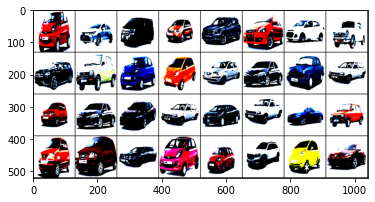

In [ ]:
diff=10
max_epoch=1500
lossmin = 100
vae_a_loss = []
for epoch in range(max_epoch):
    for idx, (data1, target) in enumerate(trainloader):
        # Training Discriminator
        data = Variable(data1)
        data, target = data.to(device), target.to(device)
        x_outputs, mu, logvar = vae(data)
        vae_loss = mse_loss(x_outputs, data, mu, logvar)
        
        vae_opt.zero_grad()
        vae_loss.backward()
        vae_opt.step()  
        scheduler.step()   
        
        vae_a_loss.append(vae_loss)
        vae_opt.zero_grad()
        
        if step%50 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            for param_group in vae_opt.param_groups:
              print("lr : ",param_group['lr'])
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, lossmin: {:.4f}, Time:{}'.format(epoch, max_epoch, step, vae_loss.item(), lossmin, dt))
            if epoch%50==0:
              imshow(torchvision.utils.make_grid(x_outputs.detach().cpu()))
            vae.train()
        step += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input
Output


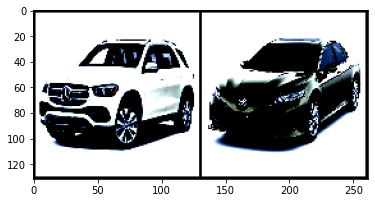

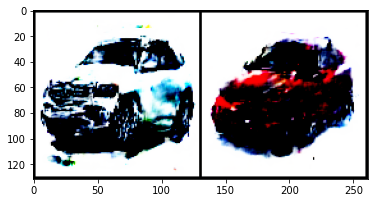

In [ ]:
data = Data()
trainloader1 = data.getDataLoader(trainset, 2)
dataiter = iter(trainloader1)
images, labels = dataiter.next()
data1 = Variable(images).to(device)
x_data, mu, logvar = vae(data1)
print("Input")
imshow(torchvision.utils.make_grid(data1.detach().cpu()))
plt.figure(0)
print("Output")
imshow(torchvision.utils.make_grid(x_data.detach().cpu()))

#Saving model

In [ ]:
torch.save(vae.state_dict(), 'vae_finale.pt')

#Loading model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input
Output


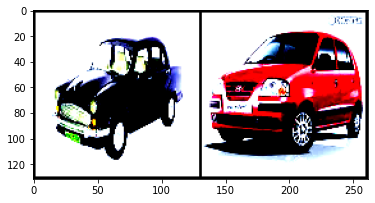

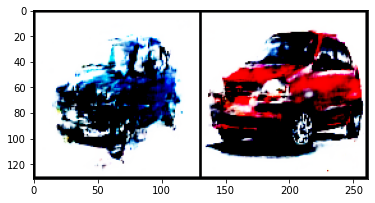

In [ ]:
vae.load_state_dict(torch.load('vae_finale.pt'))
dataiter = iter(trainloader1)
images, labels = dataiter.next()
data1 = Variable(images).to(device)
x_data, mu, logvar = vae(data1)
print("Input")
imshow(torchvision.utils.make_grid(data1.detach().cpu()))
plt.figure(0)
print("Output")
imshow(torchvision.utils.make_grid(x_data.detach().cpu()))

#Random Latent Image Generation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

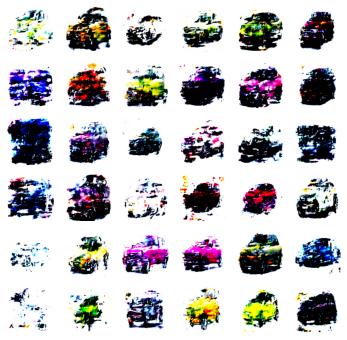

In [ ]:
vae.load_state_dict(torch.load('vae_finale.pt'))
sample = Variable(torch.randn(36, ZDIMS)).to(device)
sample1 = vae.decode(sample)
img = sample1.view(36, 3, 128, 128).permute(0, 2, 3, 1)
img = (img.detach().cpu().numpy())  #/2.
plt.figure(figsize = (6,6))
gs1 = gridspec.GridSpec(6, 6)
gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 
for i in range(1,37):
    plt.subplot(6, 6, i)
    plt.axis('off')
    plt.imshow(img[i-1], 'gray')
plt.show()

#Plotting loss curve

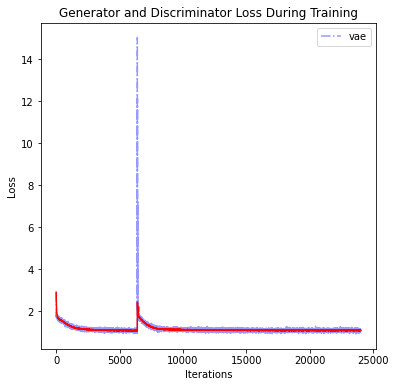

In [ ]:
def smooth_curv(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return np.array(smoothed)
    

plt.figure(figsize = (6,6))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(vae_a_loss, 'b-.',label="vae", alpha=0.4)
plt.plot(smooth_curv(vae_a_loss, 0.95), 'r')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Saving and loading model in onnx

In [ ]:
!pip install onnx onnxruntime

     |████████████████████████████████| 7.4MB 4.6MB/s 
     |████████████████████████████████| 4.4MB 40.6MB/s 


In [ ]:
import io
import numpy as np
import torch.onnx
import copy

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def print_size_of_onnx_model(model):
    onnx.save(model, 'temp.onnx')
    print('Size (MB):', os.path.getsize("temp.onnx")/1e6)
    os.remove('temp.onnx')

In [ ]:
print_size_of_model(vae)

Size (MB): 61.176496


In [ ]:
# Input to the model
torch_model = copy.deepcopy(vae)
torch_model = torch_model.to(device)
print(next(torch_model.parameters()).is_cuda)
batch_size = 1

x = torch.randn(64,256).to(device)
torch_out = torch_model.decode(x)

True


In [ ]:
# Export the model
x = torch.randn(1,3,128,128).to(device)
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "cars_vae.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  # verbose = True,
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=False,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [ ]:
torch_out.shape

torch.Size([64, 3, 128, 128])

In [ ]:
import onnx

onnx_model = onnx.load("cars_vae.onnx")

## verify the model’s structure and confirm that the model has a valid schema ##
onnx.checker.check_model(onnx_model)

In [ ]:
print_size_of_onnx_model(onnx_model)

Size (MB): 61.164337


In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("cars_vae.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
z1 = np.random.randn(1,3,128,128).astype(np.float32)
print(z1.shape)
ort_inputs = {ort_session.get_inputs()[0].name:z1}
ort_outs = ort_session.run(None, ort_inputs)
#np.array(ort_outs).shape

(1, 3, 128, 128)


#Quantized model creation

In [ ]:
from onnxruntime.quantization import quantize
from onnxruntime.quantization import QuantizationMode

In [ ]:
quantized_model = quantize(onnx_model, quantization_mode=QuantizationMode.IntegerOps, static=False)
onnx.save(quantized_model, 'cars.quantized.onnx')
print_size_of_onnx_model(quantized_model)

Size (MB): 49.442775


In [ ]:
data = Data()
trainloader1 = data.getDataLoader(trainset, 1)

In [ ]:
dataiter = iter(trainloader1)
images, labels = dataiter.next()
data1 = Variable(images)
image1 = np.array(data1)

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("cars.quantized.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
z1 = image1.astype(np.float32) 
ort_inputs = {ort_session.get_inputs()[0].name:z1}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs1 = ort_outs[0]
ort_outs1.shape

(1, 3, 128, 128)

#Getting result from Quantized model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


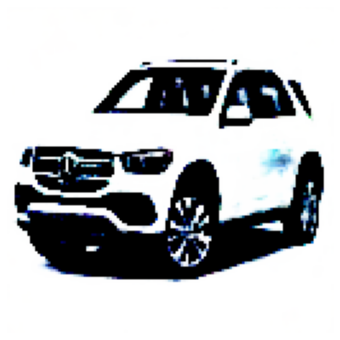

In [ ]:
img = np.transpose(ort_outs1, (0, 2, 3, 1))
plt.figure(figsize = (6,6))
gs1 = gridspec.GridSpec(6, 6)
gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 
for i in range(1,2):
        plt.subplot(1, 1, i)
        plt.axis('off')
        plt.imshow(img[0])
plt.show() 

#Display Original Image for comparison

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


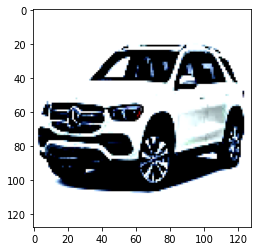

In [ ]:
from google.colab.patches import cv2_imshow
imshow(torchvision.utils.make_grid(images))

In [ ]:
!mv /content/vae_finale.pt "/content/gdrive/My Drive/eva-4/Phase-2/Session-7/generalization"